# Inference simple

In [1]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
from torch_geometric.data import Batch

class DTAPredictor:
    """Simple predictor for drug-target affinity."""
    
    def __init__(self, model_path, config_path=None, device='cuda'):
        """
        Args:
            model_path: Path to saved model checkpoint
            config_path: Path to config file (optional)
            device: Device to run on
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load config
        if config_path and Path(config_path).exists():
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        else:
            # Default config
            self.config = {
                'task_cols': ['pKi', 'pEC50', 'pKd', 'pIC50', 'pKd (Wang, FEP)', 'potency'],
                'model_config': {
                    'prot_emb_dim': 1280,
                    'prot_gcn_dims': [128, 256, 256],
                    'prot_fc_dims': [1024, 128],
                    'drug_node_in_dim': [66, 1],
                    'drug_node_h_dims': [128, 64],
                    'drug_edge_in_dim': [16, 1],
                    'drug_edge_h_dims': [32, 1],
                    'drug_fc_dims': [1024, 128],
                    'mlp_dims': [1024, 512],
                    'mlp_dropout': 0.25
                }
            }
        
        # Load model
        
        self.model = MTL_DTAModel(
            task_names=self.config['task_cols'],
            **self.config['model_config']
        ).to(self.device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        self.model.eval()
        
        # Initialize processors
        self._init_processors()
    
    def _init_processors(self):
        """Initialize standardization and featurization."""
        from rdkit import Chem
        from rdkit.Chem import AllChem
        from Bio.PDB import PDBParser
        self.pdb_parser = PDBParser(QUIET=True)
        
    def predict(self, protein_ligand_pairs):
        """
        Predict affinities for protein-ligand pairs.
        
        Args:
            protein_ligand_pairs: List of tuples (protein_path, ligand_path) or
                                 DataFrame with 'protein_path' and 'ligand_path' columns
        
        Returns:
            DataFrame with predictions for each task
        """
        # Convert to DataFrame if needed
        if isinstance(protein_ligand_pairs, list):
            df = pd.DataFrame(protein_ligand_pairs, 
                            columns=['protein_path', 'ligand_path'])
        else:
            df = protein_ligand_pairs.copy()
        
        # Process and predict
        predictions = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Predicting"):
            try:
                # Featurize
                drug_graph = self._featurize_drug(row['ligand_path'])
                prot_graph = self._featurize_protein(row['protein_path'])
                
                # Create batch
                

                drug_batch = Batch.from_data_list([drug_graph]).to(self.device)
                prot_batch = Batch.from_data_list([prot_graph]).to(self.device)
                
                # Predict
                with torch.no_grad():
                    pred = self.model(drug_batch, prot_batch)
                    pred = pred.cpu().numpy()[0]  # Get first (only) batch item
                
                # Store predictions
                pred_dict = {task: pred[i] for i, task in enumerate(self.config['task_cols'])}
                predictions.append(pred_dict)
                
            except Exception as e:
                print(f"Error processing {idx}: {e}")
                pred_dict = {task: np.nan for task in self.config['task_cols']}
                predictions.append(pred_dict)
        
        # Create results DataFrame
        results_df = pd.DataFrame(predictions)
        results_df = pd.concat([df[['protein_path', 'ligand_path']], results_df], axis=1)
        
        return results_df
    
    def _featurize_drug(self, sdf_path):
        """Quick drug featurization."""
        import torch_geometric
        from rdkit import Chem
        import torch_cluster
        
        mol = Chem.MolFromMolFile(sdf_path)
        if mol is None:
            raise ValueError(f"Could not read molecule from {sdf_path}")
        
        # Get coordinates
        conf = mol.GetConformer()
        coords = torch.tensor(conf.GetPositions(), dtype=torch.float32)
        
        # Simple atom features (simplified)
        atom_features = []
        for atom in mol.GetAtoms():
            features = [
                atom.GetAtomicNum(),
                atom.GetDegree(),
                atom.GetTotalNumHs(),
                int(atom.GetIsAromatic())
            ]
            atom_features.append(features)
        
        atom_features = torch.tensor(atom_features, dtype=torch.float32)
        
        # Create edges (radius graph)
        edge_index = torch_cluster.radius_graph(coords, r=4.5)
        
        # Create minimal graph
        data = torch_geometric.data.Data(
            x=coords,
            edge_index=edge_index,
            node_s=atom_features,
            node_v=coords.unsqueeze(1),
            edge_s=torch.ones(edge_index.size(1), 16),  # Dummy edge features
            edge_v=torch.ones(edge_index.size(1), 1, 3)  # Dummy edge vectors
        )
        
        return data
    
    def _featurize_protein(self, pdb_path):
        """Quick protein featurization."""
        import torch_geometric
        import torch_cluster
        
        # Parse PDB
        structure = self.pdb_parser.get_structure('protein', pdb_path)
        
        # Get CA coordinates
        ca_coords = []
        for model in structure:
            for chain in model:
                for residue in chain:
                    if 'CA' in residue:
                        ca_coords.append(residue['CA'].coord)
                if ca_coords:  # Use first chain only
                    break
            break
        
        coords = torch.tensor(ca_coords, dtype=torch.float32)
        
        # Create edges
        edge_index = torch_cluster.radius_graph(coords, r=8.0)
        
        # Dummy features
        seq_len = len(coords)
        seq = torch.zeros(seq_len, dtype=torch.long)  # Dummy sequence
        node_s = torch.randn(seq_len, 6)  # Dummy dihedral features
        node_v = torch.randn(seq_len, 3, 3)  # Dummy orientations
        seq_emb = torch.randn(seq_len, 1280)  # Dummy ESM embeddings
        
        # Create graph
        data = torch_geometric.data.Data(
            x=coords,
            seq=seq,
            edge_index=edge_index,
            node_s=node_s,
            node_v=node_v,
            edge_s=torch.randn(edge_index.size(1), 39),
            edge_v=torch.randn(edge_index.size(1), 1, 3),
            seq_emb=seq_emb
        )
        
        return data


# ============ SIMPLE USAGE ============

def predict_affinity(
    model_path,
    protein_ligand_pairs,
    output_path=None,
    device='cuda'
):
    """
    Simple function to predict affinities.
    
    Args:
        model_path: Path to trained model
        protein_ligand_pairs: List of (protein_pdb, ligand_sdf) or DataFrame
        output_path: Optional path to save predictions
        device: Device to use
    
    Returns:
        DataFrame with predictions
    """
    # Initialize predictor
    predictor = DTAPredictor(model_path, device=device)
    
    # Predict
    results = predictor.predict(protein_ligand_pairs)
    
    # Save if requested
    if output_path:
        results.to_csv(output_path, index=False)
        print(f"Predictions saved to {output_path}")
    
    return results

In [2]:
from Bio.PDB import PDBParser
from Bio.PDB import MMCIFParser, PDBIO, Select

class ProteinSelect(Select):
    def accept_residue(self, residue):
        return residue.get_id()[0] == ' '

    
class LigandSelect(Select):
    def accept_residue(self, residue):
        return residue.get_id()[0] != ' '
        
def check_files_exist_and_valid(protein_path, ligand_path, min_size_bytes=50):
    """Check if both protein and ligand files exist and are valid"""
    try:
        if not (os.path.exists(protein_path) and os.path.exists(ligand_path)):
            return False
        
        protein_size = os.path.getsize(protein_path)
        ligand_size = os.path.getsize(ligand_path)
        
        if protein_size < min_size_bytes or ligand_size < min_size_bytes:
            return False
            
        # Quick content validation
        try:
            with open(protein_path, 'r') as f:
                first_line = f.readline().strip()
                if not (first_line.startswith(('ATOM', 'HETATM', 'MODEL', 'HEADER'))):
                    return False
            
            with open(ligand_path, 'r') as f:
                content = f.read(100)
                if len(content.strip()) < 10:
                    return False
                    
        except Exception:
            return False
            
        return True
        
    except Exception:
        return False

def process_single(input_path, protein_dir, ligand_dir):
    """Process a single CIF file"""
    input_filename = os.path.basename(input_path)
    
    # Parse CIF file
    if input_path.endswith(".cif"):
        parser = MMCIFParser(QUIET=True)
        pdb_filename = input_filename.replace(".cif", ".pdb")
        sdf_filename = input_filename.replace(".cif", ".sdf")

    if input_path.endswith(".pdb"):
        parser = PDBParser(QUIET=True)
        pdb_filename = input_filename.replace(".pdb", ".pdb")
        sdf_filename = input_filename.replace(".pdb", ".sdf")

        
    
    pdb_path = os.path.join(str(protein_dir), str(pdb_filename))
    sdf_path = os.path.join(str(ligand_dir), str(sdf_filename))
    
    # Skip if files already exist and are valid
    if check_files_exist_and_valid(pdb_path, sdf_path):
        return {
            'protein_path': pdb_path,
            'ligand_path': sdf_path,
            'status': 'already_exists',
            'success': True
        }
    
    # Clean up any partially created files
    for path in [pdb_path, sdf_path]:
        if os.path.exists(path) :
            try:
                os.remove(path)
            except:
                pass
    
    try:
        # Parse CIF file
        structure = parser.get_structure("complex", input_path)
        
        # Write protein PDB
        io = PDBIO()
        io.set_structure(structure)
        io.save(pdb_path, select=ProteinSelect())
        
        # Write ligand to temporary PDB first
        ligand_temp_pdb = sdf_path.replace(".sdf", "_temp.pdb")
        io.save(ligand_temp_pdb, select=LigandSelect())
        
        # Convert ligand PDB to SDF using RDKit
        mol = rdmolfiles.MolFromPDBFile(ligand_temp_pdb, removeHs=False)
        
        if mol is not None:
            writer = Chem.SDWriter(sdf_path)
            writer.write(mol)
            writer.close()
            
            # Clean up temp file
            if os.path.exists(ligand_temp_pdb):
                os.remove(ligand_temp_pdb)
            
            # Final validation
            if check_files_exist_and_valid(pdb_path, sdf_path):
                return {
                    'protein_path': pdb_path,
                    'ligand_path': sdf_path,
                    'status': 'converted_successfully',
                    'success': True
                }
            else:
                return {
                    'protein_path': pdb_path,
                    'ligand_path': sdf_path,
                    'status': 'validation_failed',
                    'success': False
                }
        else:
            # RDKit conversion failed
            if os.path.exists(ligand_temp_pdb):
                os.remove(ligand_temp_pdb)
            return {
                'protein_path': pdb_path,
                'ligand_path': sdf_path,
                'status': 'rdkit_failed',
                'success': False
            }
            
    except Exception as e:
        # Clean up any partial files
        for path in [pdb_path, sdf_path]:
            if os.path.exists(path):
                try:
                    os.remove(path)
                except:
                    pass
                    
        return {
            'protein_path': pdb_path,
            'ligand_path': sdf_path,
            'status': f'error: {str(e)}',
            'success': False
        }


In [3]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import torch_geometric
from torch_geometric.data import Batch
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
import os
import tempfile

class DTAPredictor:
    """Simple predictor for drug-target affinity."""
    
    def __init__(self, model_path, config_path=None, device='cuda', esm_model=None):
        """
        Args:
            model_path: Path to saved model checkpoint
            config_path: Path to config file (optional)
            device: Device to run on
            esm_model: Pre-loaded ESM model (optional)
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load config
        if config_path and Path(config_path).exists():
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        else:
            # Default config
            self.config = {
                'task_cols': ['pKi', 'pEC50', 'pKd', 'pIC50', 'pKd (Wang, FEP)', 'potency'],
                'model_config': {
                    'prot_emb_dim': 1280,
                    'prot_gcn_dims': [128, 256, 256],
                    'prot_fc_dims': [1024, 128],
                    'drug_node_in_dim': [66, 1],
                    'drug_node_h_dims': [128, 64],
                    'drug_edge_in_dim': [16, 1],
                    'drug_edge_h_dims': [32, 1],
                    'drug_fc_dims': [1024, 128],
                    'mlp_dims': [1024, 512],
                    'mlp_dropout': 0.25
                }
            }
        
        # Load model
        self.model = MTL_DTAModel(
            task_names=self.config['task_cols'],
            **self.config['model_config']
        ).to(self.device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        self.model.eval()
        
        # Initialize ESM model for protein embeddings
        if esm_model is not None:
            self.esm_model = esm_model
            self.tokenizer = None
        else:
            from transformers import EsmModel, EsmTokenizer
            model_name = "facebook/esm2_t33_650M_UR50D"
            self.tokenizer = EsmTokenizer.from_pretrained(model_name)
            self.esm_model = EsmModel.from_pretrained(model_name)
            self.esm_model.eval()
            self.esm_model = self.esm_model.to(self.device)
        
        # Initialize parser
        self.parser = PDBParser(QUIET=True)
        
        print(f"✓ Model loaded from {model_path}")
        print(f"✓ Using device: {self.device}")
        
    def extract_backbone_coords(self, structure, pdb_id, pdb_path):
        """Extract backbone coordinates from protein structure (from your code)."""
        coords = {"N": [], "CA": [], "C": [], "O": []}
        seq = ""
        
        model = structure[0]
        
        # Find valid chain
        valid_chain = None
        for chain in model:
            for res in chain:
                if res.id[0] == ' ':  # Standard amino acid
                    valid_chain = chain
                    break
            if valid_chain:
                break
        
        if valid_chain is None:
            return None, None, None
        
        chain_id = valid_chain.id
        
        # Extract coordinates and sequence
        for res in valid_chain:
            if res.id[0] != ' ':  # Skip non-standard residues
                continue
            
            # Get one-letter code
            try:
                seq += seq1(res.resname)
            except:
                seq += 'X'  # Unknown residue
            
            # Get backbone atom coordinates
            for atom_name in ["N", "CA", "C", "O"]:
                if atom_name in res:
                    coords[atom_name].append(res[atom_name].coord.tolist())
                else:
                    coords[atom_name].append([float("nan")] * 3)
        
        return seq, coords, chain_id
    
    def get_esm_embedding(self, seq):
        """Get ESM embedding for sequence (from your code)."""
        if self.tokenizer is None:
            from transformers import EsmTokenizer
            self.tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
        
        inputs = self.tokenizer(seq, return_tensors="pt", truncation=True, max_length=1024)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.esm_model(**inputs)
            # Remove CLS and EOS tokens
            embedding = outputs.last_hidden_state[0, 1:-1]
        
        return embedding
    
    def create_protein_structure_dict(self, pdb_path):
        """Create protein structure dictionary with real ESM embeddings."""
        pdb_id = os.path.basename(pdb_path).split('.')[0]
        
        structure = self.parser.get_structure(pdb_id, pdb_path)
        seq, coords, chain_id = self.extract_backbone_coords(structure, pdb_id, pdb_path)
        
        if seq is None:
            raise ValueError(f"No valid chain found in {pdb_path}")
        
        # Stack coordinates in order: N, CA, C, O
        coords_stacked = []
        for i in range(len(coords["N"])):
            coord_group = []
            for atom in ["N", "CA", "C", "O"]:
                coord_group.append(coords[atom][i])
            coords_stacked.append(coord_group)
        
        # Get ESM embedding
        embedding = self.get_esm_embedding(seq)
        
        # Save embedding temporarily
        with tempfile.NamedTemporaryFile(suffix='.pt', delete=False) as f:
            torch.save(embedding.cpu(), f.name)
            embed_path = f.name
        
        structure_dict = {
            "name": pdb_id,
            "UniProt_id": "UNKNOWN",
            "PDB_id": pdb_id,
            "chain": chain_id,
            "seq": seq,
            "coords": coords_stacked,
            "embed": embed_path
        }
        
        return structure_dict
    
    #def predict(self, protein_ligand_pairs):
    #    """
    #    Predict affinities for protein-ligand pairs.
    #    
    #    Args:
    #        protein_ligand_pairs: List of tuples (protein_path, ligand_path) or
    #                             DataFrame with 'protein_path' and 'ligand_path' columns
    #    
    #    Returns:
    #        DataFrame with predictions for each task
    #    """
    #    # Import featurization functions
    #    
    #    # Convert to DataFrame if needed
    #    if isinstance(protein_ligand_pairs, list):
    #        df = pd.DataFrame(protein_ligand_pairs, 
    #                        columns=['protein_path', 'ligand_path'])
    #    else:
    #        df = protein_ligand_pairs.copy()
    #    
    #    # Process and predict
    #    predictions = []
    #    
    #    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Predicting"):
    #        try:
    #            # Featurize drug
    #            drug_graph = featurize_drug(row['ligand_path'])
    #            
    #            # Create protein structure with real ESM embeddings
    #            protein_struct = self.create_protein_structure_dict(row['protein_path'])
    #            
    #            # Featurize protein
    #            prot_graph = featurize_protein_graph(protein_struct)
    #            
    #            # Batch the data properly
    #            drug_batch = Batch.from_data_list([drug_graph]).to(self.device)
    #            prot_batch = Batch.from_data_list([prot_graph]).to(self.device)
    #            
    #            # Predict
    #            with torch.no_grad():
    #                pred = self.model(drug_batch, prot_batch)
    #                pred = pred.cpu().numpy()[0]  # Get first (only) batch item
    #            
    #            # Store predictions
    #            pred_dict = {task: float(pred[i]) for i, task in enumerate(self.config['task_cols'])}
    #            predictions.append(pred_dict)
    #            
    #            # Clean up temp embedding file
    #            if os.path.exists(protein_struct['embed']):
    #                os.remove(protein_struct['embed'])
    #            
    #        except Exception as e:
    #            print(f"Error processing {idx} ({row['protein_path']}): {e}")
    #            pred_dict = {task: np.nan for task in self.config['task_cols']}
    #            predictions.append(pred_dict)
    #    
    #    # Create results DataFrame
    #    results_df = pd.DataFrame(predictions)
    #    results_df = pd.concat([df[['protein_path', 'ligand_path']], results_df], axis=1)
    #    
    #    return results_df

    def predict(self, protein_ligand_pairs):
        """
        Predict affinities for protein-ligand pairs.

        Args:
            protein_ligand_pairs: List of tuples (protein_path, ligand_path) or
                                 DataFrame with 'protein_path' and 'ligand_path' columns

        Returns:
            DataFrame with predictions for each task
        """
        # Convert to DataFrame if needed
        if isinstance(protein_ligand_pairs, list):
            df = pd.DataFrame(protein_ligand_pairs, 
                            columns=['protein_path', 'ligand_path'])
        else:
            df = protein_ligand_pairs.copy()

        # Step 1: Featurize all pairs
        drug_graphs = []
        prot_graphs = []
        valid_indices = []
        temp_embed_files = []

        print("Featurizing all protein-ligand pairs...")
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Featurizing"):
            try:
                # Featurize drug
                drug_graph = featurize_drug(row['ligand_path'])

                # Create protein structure with real ESM embeddings
                protein_struct = self.create_protein_structure_dict(row['protein_path'])
                temp_embed_files.append(protein_struct['embed'])

                # Featurize protein
                prot_graph = featurize_protein_graph(protein_struct)

                # Store graphs
                drug_graphs.append(drug_graph)
                prot_graphs.append(prot_graph)
                valid_indices.append(idx)

            except Exception as e:
                print(f"Error featurizing {idx} ({row['protein_path']}): {e}")

        # Step 2: Batch all data
        if drug_graphs:
            drug_batch = Batch.from_data_list(drug_graphs).to(self.device)
            prot_batch = Batch.from_data_list(prot_graphs).to(self.device)

            # Step 3: Predict on full batch
            print("Running batch prediction...")
            with torch.no_grad():
                batch_preds = self.model(drug_batch, prot_batch)
                batch_preds = batch_preds.cpu().numpy()

        # Step 4: Format results
        predictions = []
        pred_idx = 0

        for idx in range(len(df)):
            if idx in valid_indices:
                # Get predictions for this sample
                pred = batch_preds[pred_idx]
                pred_dict = {task: float(pred[i]) for i, task in enumerate(self.config['task_cols'])}
                pred_idx += 1
            else:
                # Failed featurization - use NaN
                pred_dict = {task: np.nan for task in self.config['task_cols']}

            predictions.append(pred_dict)

        # Clean up temp embedding files
        for embed_file in temp_embed_files:
            if os.path.exists(embed_file):
                os.remove(embed_file)

        # Create results DataFrame
        results_df = pd.DataFrame(predictions)
        results_df = pd.concat([df[['protein_path', 'ligand_path']], results_df], axis=1)

        return results_df

def predict_affinity(
    model_path,
    protein_ligand_pairs,
    output_path=None,
    device='cuda',
    esm_model=None
):
    """
    Simple function to predict affinities with real featurization.
    
    Args:
        model_path: Path to trained model
        protein_ligand_pairs: List of (protein_pdb, ligand_sdf) or DataFrame
        output_path: Optional path to save predictions
        device: Device to use
        esm_model: Pre-loaded ESM model (optional, will load if not provided)
    
    Returns:
        DataFrame with predictions
    """
    # Initialize predictor
    predictor = DTAPredictor(model_path, device=device, esm_model=esm_model)
    
    # Predict
    results = predictor.predict(protein_ligand_pairs)
    
    # Save if requested
    if output_path:
        results.to_csv(output_path, index=False)
        print(f"Predictions saved to {output_path}")
    
    return results

In [4]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import torch_geometric
from torch_geometric.data import Batch
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
import os
import tempfile
from joblib import Parallel, delayed
from tqdm import tqdm
import os
def process_row(idx, row, parser, extract_backbone_coords):
    try:
        pdb_path = row['protein_path']
        pdb_id = os.path.basename(pdb_path).split('.')[0]
        structure = parser.get_structure(pdb_id, pdb_path)
        seq, coords, chain_id = extract_backbone_coords(structure, pdb_id, pdb_path)
        if seq is None:
            raise ValueError(f"No valid chain found in {pdb_path}")
        return {
            'idx': idx,
            'pdb_path': pdb_path,
            'seq': seq,
            'coords': coords,
            'chain_id': chain_id,
            'pdb_id': pdb_id
        }
    except Exception as e:
        print(f"Error parsing PDB {idx} ({row['protein_path']}): {e}")
        return None
    
class DTAPredictor:
    """Simple predictor for drug-target affinity with batched ESM embeddings."""
    
    def __init__(self, model_path, config_path=None, device='cuda', esm_model=None):
        """
        Args:
            model_path: Path to saved model checkpoint
            config_path: Path to config file (optional)
            device: Device to run on
            esm_model: Pre-loaded ESM model (optional)
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load config
        if config_path and Path(config_path).exists():
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        else:
            # Default config
            self.config = {
                'task_cols': ['pKi', 'pEC50', 'pKd', 'pIC50', 'pKd (Wang, FEP)', 'potency'],
                'model_config': {
                    'prot_emb_dim': 1280,
                    'prot_gcn_dims': [128, 256, 256],
                    'prot_fc_dims': [1024, 128],
                    'drug_node_in_dim': [66, 1],
                    'drug_node_h_dims': [128, 64],
                    'drug_edge_in_dim': [16, 1],
                    'drug_edge_h_dims': [32, 1],
                    'drug_fc_dims': [1024, 128],
                    'mlp_dims': [1024, 512],
                    'mlp_dropout': 0.25
                }
            }
        
        # Load model
        self.model = MTL_DTAModel(
            task_names=self.config['task_cols'],
            **self.config['model_config']
        ).to(self.device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        self.model.eval()
        
        # Initialize ESM model for protein embeddings
        if esm_model is not None:
            self.esm_model = esm_model
            self.tokenizer = None
        else:
            from transformers import EsmModel, EsmTokenizer
            model_name = "facebook/esm2_t33_650M_UR50D"
            self.tokenizer = EsmTokenizer.from_pretrained(model_name)
            self.esm_model = EsmModel.from_pretrained(model_name)
            self.esm_model.eval()
            self.esm_model = self.esm_model.to(self.device)
        
        # Initialize parser
        self.parser = PDBParser(QUIET=True)
        
        print(f"✓ Model loaded from {model_path}")
        print(f"✓ Using device: {self.device}")
        
    def extract_backbone_coords(self, structure, pdb_id, pdb_path):
        """Extract backbone coordinates from protein structure (from your code)."""
        coords = {"N": [], "CA": [], "C": [], "O": []}
        seq = ""
        
        model = structure[0]
        
        # Find valid chain
        valid_chain = None
        for chain in model:
            for res in chain:
                if res.id[0] == ' ':  # Standard amino acid
                    valid_chain = chain
                    break
            if valid_chain:
                break
        
        if valid_chain is None:
            return None, None, None
        
        chain_id = valid_chain.id
        
        # Extract coordinates and sequence
        for res in valid_chain:
            if res.id[0] != ' ':  # Skip non-standard residues
                continue
            
            # Get one-letter code
            try:
                seq += seq1(res.resname)
            except:
                seq += 'X'  # Unknown residue
            
            # Get backbone atom coordinates
            for atom_name in ["N", "CA", "C", "O"]:
                if atom_name in res:
                    coords[atom_name].append(res[atom_name].coord.tolist())
                else:
                    coords[atom_name].append([float("nan")] * 3)
        
        return seq, coords, chain_id
    
    def get_esm_embeddings_batch(self, sequences, batch_size=250):
        """Get ESM embeddings for a batch of sequences."""
        if self.tokenizer is None:
            from transformers import EsmTokenizer
            self.tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
        
        all_embeddings = []
        
        # Process in batches
        for i in tqdm(range(0, len(sequences), batch_size), desc="Processing ESM batches"):
            batch_seqs = sequences[i:i + batch_size]
            
            # Tokenize batch
            inputs = self.tokenizer(
                batch_seqs, 
                return_tensors="pt", 
                truncation=True, 
                max_length=1024,
                padding=True,
                add_special_tokens=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.esm_model(**inputs)
                # Remove CLS and EOS tokens for each sequence
                batch_embeddings = []
                for j, seq in enumerate(batch_seqs):
                    # Get the actual sequence length (excluding padding)
                    seq_len = len(seq)
                    # Extract embedding without CLS and EOS tokens, up to actual sequence length
                    embedding = outputs.last_hidden_state[j, 1:seq_len+1]  # Skip CLS, take only actual sequence
                    batch_embeddings.append(embedding.cpu())
                
                all_embeddings.extend(batch_embeddings)
            
            # Clear GPU memory
            del inputs, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return all_embeddings
    
    def create_protein_structure_dict_with_embedding(self, pdb_path, embedding):
        """Create protein structure dictionary with pre-computed ESM embedding."""
        pdb_id = os.path.basename(pdb_path).split('.')[0]
        
        structure = self.parser.get_structure(pdb_id, pdb_path)
        seq, coords, chain_id = self.extract_backbone_coords(structure, pdb_id, pdb_path)
        
        if seq is None:
            raise ValueError(f"No valid chain found in {pdb_path}")
        
        # Stack coordinates in order: N, CA, C, O
        coords_stacked = []
        for i in range(len(coords["N"])):
            coord_group = []
            for atom in ["N", "CA", "C", "O"]:
                coord_group.append(coords[atom][i])
            coords_stacked.append(coord_group)
        
        # Save embedding temporarily
        with tempfile.NamedTemporaryFile(suffix='.pt', delete=False) as f:
            torch.save(embedding, f.name)
            embed_path = f.name
        
        structure_dict = {
            "name": pdb_id,
            "UniProt_id": "UNKNOWN",
            "PDB_id": pdb_id,
            "chain": chain_id,
            "seq": seq,
            "coords": coords_stacked,
            "embed": embed_path
        }
        
        return structure_dict

    def predict(self, protein_ligand_pairs):
        """
        Predict affinities for protein-ligand pairs with batched ESM processing.

        Args:
            protein_ligand_pairs: List of tuples (protein_path, ligand_path) or
                                 DataFrame with 'protein_path' and 'ligand_path' columns

        Returns:
            DataFrame with predictions for each task
        """
        # Convert to DataFrame if needed
        if isinstance(protein_ligand_pairs, list):
            df = pd.DataFrame(protein_ligand_pairs, 
                            columns=['protein_path', 'ligand_path'])
        else:
            df = protein_ligand_pairs.copy()

        # # Step 1: Extract all protein sequences first
        # print("Extracting protein sequences...")
        # protein_sequences = []
        # protein_structures = []
        # sequence_to_indices = {}  # Map sequence to indices that use it
        # 
        # for idx, row in tqdm(df.iterrows(), total=len(df), desc="Parsing PDBs"):
        #     try:
        #         pdb_path = row['protein_path']
        #         pdb_id = os.path.basename(pdb_path).split('.')[0]
        #         structure = self.parser.get_structure(pdb_id, pdb_path)
        #         seq, coords, chain_id = self.extract_backbone_coords(structure, pdb_id, pdb_path)
        #         
        #         if seq is None:
        #             raise ValueError(f"No valid chain found in {pdb_path}")
        #         
        #         # Store structure info
        #         protein_structures.append({
        #             'idx': idx,
        #             'pdb_path': pdb_path,
        #             'seq': seq,
        #             'coords': coords,
        #             'chain_id': chain_id,
        #             'pdb_id': pdb_id
        #         })
        #         
        #         # Track unique sequences
        #         if seq not in sequence_to_indices:
        #             sequence_to_indices[seq] = []
        #             protein_sequences.append(seq)
        #         sequence_to_indices[seq].append(idx)
        #         
        #     except Exception as e:
        #         print(f"Error parsing PDB {idx} ({row['protein_path']}): {e}")
        #         protein_structures.append(None)
        

        
        
        
        
        print("Extracting protein sequences in parallel...")
        
        results = Parallel(n_jobs=-1)(
            delayed(process_row)(idx, row, self.parser, self.extract_backbone_coords)
            for idx, row in tqdm(df.iterrows(), total=len(df), desc="Parsing PDBs")
        )
        
        protein_structures = []
        protein_sequences = []
        sequence_to_indices = {}
        
        for res in results:
            if res is None:
                protein_structures.append(None)
                continue
        
            seq = res['seq']
            protein_structures.append(res)
        
            if seq not in sequence_to_indices:
                sequence_to_indices[seq] = []
                protein_sequences.append(seq)
            sequence_to_indices[seq].append(res['idx'])

        
        
        
        
        
        # Step 2: Get ESM embeddings for all unique sequences in batches
        print(f"Getting ESM embeddings for {len(protein_sequences)} unique sequences...")
        unique_embeddings = self.get_esm_embeddings_batch(protein_sequences, batch_size=250)
        
        # Create mapping from sequence to embedding
        seq_to_embedding = {seq: emb for seq, emb in zip(protein_sequences, unique_embeddings)}
        
        # Step 3: Featurize all pairs
        drug_graphs = []
        prot_graphs = []
        valid_indices = []
        temp_embed_files = []

        print("Featurizing all protein-ligand pairs...")
        for struct_info in tqdm(protein_structures, desc="Featurizing"):
            if struct_info is None:
                continue
                
            idx = struct_info['idx']
            row = df.iloc[idx]
            
            try:
                # Featurize drug
                drug_graph = featurize_drug(row['ligand_path'])

                # Get embedding for this sequence
                embedding = seq_to_embedding[struct_info['seq']]
                
                # Create protein structure dict with pre-computed embedding
                protein_struct = self.create_protein_structure_dict_with_embedding(
                    struct_info['pdb_path'], 
                    embedding
                )
                temp_embed_files.append(protein_struct['embed'])

                # Featurize protein
                prot_graph = featurize_protein_graph(protein_struct)

                # Store graphs
                drug_graphs.append(drug_graph)
                prot_graphs.append(prot_graph)
                valid_indices.append(idx)

            except Exception as e:
                print(f"Error featurizing {idx} ({row['protein_path']}): {e}")

        # Step 4: Batch all data
        if drug_graphs:
            drug_batch = Batch.from_data_list(drug_graphs).to(self.device)
            prot_batch = Batch.from_data_list(prot_graphs).to(self.device)

            # Step 5: Predict on full batch
            print("Running batch prediction...")
            with torch.no_grad():
                batch_preds = self.model(drug_batch, prot_batch)
                batch_preds = batch_preds.cpu().numpy()

        # Step 6: Format results
        predictions = []
        pred_idx = 0

        for idx in range(len(df)):
            if idx in valid_indices:
                # Get predictions for this sample
                pred = batch_preds[pred_idx]
                pred_dict = {task: float(pred[i]) for i, task in enumerate(self.config['task_cols'])}
                pred_idx += 1
            else:
                # Failed featurization - use NaN
                pred_dict = {task: np.nan for task in self.config['task_cols']}

            predictions.append(pred_dict)

        # Clean up temp embedding files
        for embed_file in temp_embed_files:
            if os.path.exists(embed_file):
                os.remove(embed_file)

        # Create results DataFrame
        results_df = pd.DataFrame(predictions)
        results_df = pd.concat([df[['protein_path', 'ligand_path']], results_df], axis=1)

        return results_df

def predict_affinity(
    model_path,
    protein_ligand_pairs,
    output_path=None,
    device='cuda',
    esm_model=None
):
    """
    Simple function to predict affinities with batched ESM processing.
    
    Args:
        model_path: Path to trained model
        protein_ligand_pairs: List of (protein_pdb, ligand_sdf) or DataFrame
        output_path: Optional path to save predictions
        device: Device to use
        esm_model: Pre-loaded ESM model (optional, will load if not provided)
    
    Returns:
        DataFrame with predictions
    """
    # Initialize predictor
    predictor = DTAPredictor(model_path, device=device, esm_model=esm_model)
    
    # Predict
    results = predictor.predict(protein_ligand_pairs)
    
    # Save if requested
    if output_path:
        results.to_csv(output_path, index=False)
        print(f"Predictions saved to {output_path}")
    
    return results

In [5]:
# Move this function OUTSIDE the class and BEFORE any torch/scipy imports
def process_row_simple(idx, row_data):
    """Simple row processor that avoids complex imports"""
    import os
    from Bio.PDB import PDBParser
    from Bio.SeqUtils import seq1
    
    parser = PDBParser(QUIET=True)
    
    def extract_backbone_coords_simple(structure, pdb_id, pdb_path):
        """Extract backbone coordinates from protein structure."""
        coords = {"N": [], "CA": [], "C": [], "O": []}
        seq = ""
        
        model = structure[0]
        
        # Find valid chain
        valid_chain = None
        for chain in model:
            for res in chain:
                if res.id[0] == ' ':  # Standard amino acid
                    valid_chain = chain
                    break
            if valid_chain:
                break
        
        if valid_chain is None:
            return None, None, None
        
        chain_id = valid_chain.id
        
        # Extract coordinates and sequence
        for res in valid_chain:
            if res.id[0] != ' ':  # Skip non-standard residues
                continue
            
            # Get one-letter code
            try:
                seq += seq1(res.resname)
            except:
                seq += 'X'  # Unknown residue
            
            # Get backbone atom coordinates
            for atom_name in ["N", "CA", "C", "O"]:
                if atom_name in res:
                    coords[atom_name].append(res[atom_name].coord.tolist())
                else:
                    coords[atom_name].append([float("nan")] * 3)
        
        return seq, coords, chain_id
    
    try:
        pdb_path = row_data['protein_path']
        pdb_id = os.path.basename(pdb_path).split('.')[0]
        structure = parser.get_structure(pdb_id, pdb_path)
        seq, coords, chain_id = extract_backbone_coords_simple(structure, pdb_id, pdb_path)
        if seq is None:
            raise ValueError(f"No valid chain found in {pdb_path}")
        return {
            'idx': idx,
            'pdb_path': pdb_path,
            'seq': seq,
            'coords': coords,
            'chain_id': chain_id,
            'pdb_id': pdb_id
        }
    except Exception as e:
        print(f"Error parsing PDB {idx} ({row_data['protein_path']}): {e}")
        return None

# Now your main imports can go here
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import torch_geometric
from torch_geometric.data import Batch
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
import os
import tempfile
from joblib import Parallel, delayed

class DTAPredictor:
    """Simple predictor for drug-target affinity with batched ESM embeddings."""
    
    def __init__(self, model_path, config_path=None, device='cuda', esm_model=None):
        """
        Args:
            model_path: Path to saved model checkpoint
            config_path: Path to config file (optional)
            device: Device to run on
            esm_model: Pre-loaded ESM model (optional)
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load config
        if config_path and Path(config_path).exists():
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        else:
            # Default config
            self.config = {
                'task_cols': ['pKi', 'pEC50', 'pKd', 'pIC50', 'pKd (Wang, FEP)', 'potency'],
                'model_config': {
                    'prot_emb_dim': 1280,
                    'prot_gcn_dims': [128, 256, 256],
                    'prot_fc_dims': [1024, 128],
                    'drug_node_in_dim': [66, 1],
                    'drug_node_h_dims': [128, 64],
                    'drug_edge_in_dim': [16, 1],
                    'drug_edge_h_dims': [32, 1],
                    'drug_fc_dims': [1024, 128],
                    'mlp_dims': [1024, 512],
                    'mlp_dropout': 0.25
                }
            }
        
        # Load model
        self.model = MTL_DTAModel(
            task_names=self.config['task_cols'],
            **self.config['model_config']
        ).to(self.device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        self.model.eval()
        
        # Initialize ESM model for protein embeddings
        if esm_model is not None:
            self.esm_model = esm_model
            self.tokenizer = None
        else:
            from transformers import EsmModel, EsmTokenizer
            model_name = "facebook/esm2_t33_650M_UR50D"
            self.tokenizer = EsmTokenizer.from_pretrained(model_name)
            self.esm_model = EsmModel.from_pretrained(model_name)
            self.esm_model.eval()
            self.esm_model = self.esm_model.to(self.device)
        
        # Initialize parser
        self.parser = PDBParser(QUIET=True)
        
        print(f"✓ Model loaded from {model_path}")
        print(f"✓ Using device: {self.device}")
        
    def extract_backbone_coords(self, structure, pdb_id, pdb_path):
        """Extract backbone coordinates from protein structure (from your code)."""
        coords = {"N": [], "CA": [], "C": [], "O": []}
        seq = ""
        
        model = structure[0]
        
        # Find valid chain
        valid_chain = None
        for chain in model:
            for res in chain:
                if res.id[0] == ' ':  # Standard amino acid
                    valid_chain = chain
                    break
            if valid_chain:
                break
        
        if valid_chain is None:
            return None, None, None
        
        chain_id = valid_chain.id
        
        # Extract coordinates and sequence
        for res in valid_chain:
            if res.id[0] != ' ':  # Skip non-standard residues
                continue
            
            # Get one-letter code
            try:
                seq += seq1(res.resname)
            except:
                seq += 'X'  # Unknown residue
            
            # Get backbone atom coordinates
            for atom_name in ["N", "CA", "C", "O"]:
                if atom_name in res:
                    coords[atom_name].append(res[atom_name].coord.tolist())
                else:
                    coords[atom_name].append([float("nan")] * 3)
        
        return seq, coords, chain_id
    
    def get_esm_embeddings_batch(self, sequences, batch_size=250):
        """Get ESM embeddings for a batch of sequences."""
        if self.tokenizer is None:
            from transformers import EsmTokenizer
            self.tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
        
        all_embeddings = []
        
        # Process in batches
        for i in tqdm(range(0, len(sequences), batch_size), desc="Processing ESM batches"):
            batch_seqs = sequences[i:i + batch_size]
            
            # Tokenize batch
            inputs = self.tokenizer(
                batch_seqs, 
                return_tensors="pt", 
                truncation=True, 
                max_length=1024,
                padding=True,
                add_special_tokens=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.esm_model(**inputs)
                # Remove CLS and EOS tokens for each sequence
                batch_embeddings = []
                for j, seq in enumerate(batch_seqs):
                    # Get the actual sequence length (excluding padding)
                    seq_len = len(seq)
                    # Extract embedding without CLS and EOS tokens, up to actual sequence length
                    embedding = outputs.last_hidden_state[j, 1:seq_len+1]  # Skip CLS, take only actual sequence
                    batch_embeddings.append(embedding.cpu())
                
                all_embeddings.extend(batch_embeddings)
            
            # Clear GPU memory
            del inputs, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return all_embeddings
    
    def create_protein_structure_dict_with_embedding(self, pdb_path, embedding):
        """Create protein structure dictionary with pre-computed ESM embedding."""
        pdb_id = os.path.basename(pdb_path).split('.')[0]
        
        structure = self.parser.get_structure(pdb_id, pdb_path)
        seq, coords, chain_id = self.extract_backbone_coords(structure, pdb_id, pdb_path)
        
        if seq is None:
            raise ValueError(f"No valid chain found in {pdb_path}")
        
        # Stack coordinates in order: N, CA, C, O
        coords_stacked = []
        for i in range(len(coords["N"])):
            coord_group = []
            for atom in ["N", "CA", "C", "O"]:
                coord_group.append(coords[atom][i])
            coords_stacked.append(coord_group)
        
        # Save embedding temporarily
        with tempfile.NamedTemporaryFile(suffix='.pt', delete=False) as f:
            torch.save(embedding, f.name)
            embed_path = f.name
        
        structure_dict = {
            "name": pdb_id,
            "UniProt_id": "UNKNOWN",
            "PDB_id": pdb_id,
            "chain": chain_id,
            "seq": seq,
            "coords": coords_stacked,
            "embed": embed_path
        }
        
        return structure_dict

    def predict(self, protein_ligand_pairs):
        """
        Predict affinities for protein-ligand pairs with batched ESM processing.

        Args:
            protein_ligand_pairs: List of tuples (protein_path, ligand_path) or
                                 DataFrame with 'protein_path' and 'ligand_path' columns

        Returns:
            DataFrame with predictions for each task
        """
        # Convert to DataFrame if needed
        if isinstance(protein_ligand_pairs, list):
            df = pd.DataFrame(protein_ligand_pairs, 
                            columns=['protein_path', 'ligand_path'])
        else:
            df = protein_ligand_pairs.copy()

        # Step 1: Extract all protein sequences in parallel
        print("Extracting protein sequences in parallel...")
        
        # Prepare data for parallel processing (convert DataFrame rows to dicts)
        row_data = [{'protein_path': row['protein_path']} for _, row in df.iterrows()]
        
        # Use the simple function that's defined outside the class
        results = Parallel(n_jobs=-1)(
            delayed(process_row_simple)(idx, row_data[idx])
            for idx in tqdm(range(len(row_data)), desc="Parsing PDBs")
        )
        
        protein_structures = []
        protein_sequences = []
        sequence_to_indices = {}
        
        for res in results:
            if res is None:
                protein_structures.append(None)
                continue
        
            seq = res['seq']
            protein_structures.append(res)
        
            if seq not in sequence_to_indices:
                sequence_to_indices[seq] = []
                protein_sequences.append(seq)
            sequence_to_indices[seq].append(res['idx'])
        
        # Step 2: Get ESM embeddings for all unique sequences in batches
        print(f"Getting ESM embeddings for {len(protein_sequences)} unique sequences...")
        unique_embeddings = self.get_esm_embeddings_batch(protein_sequences, batch_size=250)
        
        # Create mapping from sequence to embedding
        seq_to_embedding = {seq: emb for seq, emb in zip(protein_sequences, unique_embeddings)}
        
        # Step 3: Featurize all pairs
        drug_graphs = []
        prot_graphs = []
        valid_indices = []
        temp_embed_files = []

        print("Featurizing all protein-ligand pairs...")
        for struct_info in tqdm(protein_structures, desc="Featurizing"):
            if struct_info is None:
                continue
                
            idx = struct_info['idx']
            row = df.iloc[idx]
            
            try:
                # Featurize drug
                drug_graph = featurize_drug(row['ligand_path'])

                # Get embedding for this sequence
                embedding = seq_to_embedding[struct_info['seq']]
                
                # Create protein structure dict with pre-computed embedding
                protein_struct = self.create_protein_structure_dict_with_embedding(
                    struct_info['pdb_path'], 
                    embedding
                )
                temp_embed_files.append(protein_struct['embed'])

                # Featurize protein
                prot_graph = featurize_protein_graph(protein_struct)

                # Store graphs
                drug_graphs.append(drug_graph)
                prot_graphs.append(prot_graph)
                valid_indices.append(idx)

            except Exception as e:
                print(f"Error featurizing {idx} ({row['protein_path']}): {e}")

        # Step 4: Batch all data
        if drug_graphs:
            drug_batch = Batch.from_data_list(drug_graphs).to(self.device)
            prot_batch = Batch.from_data_list(prot_graphs).to(self.device)

            # Step 5: Predict on full batch
            print("Running batch prediction...")
            with torch.no_grad():
                batch_preds = self.model(drug_batch, prot_batch)
                batch_preds = batch_preds.cpu().numpy()

        # Step 6: Format results
        predictions = []
        pred_idx = 0

        for idx in range(len(df)):
            if idx in valid_indices:
                # Get predictions for this sample
                pred = batch_preds[pred_idx]
                pred_dict = {task: float(pred[i]) for i, task in enumerate(self.config['task_cols'])}
                pred_idx += 1
            else:
                # Failed featurization - use NaN
                pred_dict = {task: np.nan for task in self.config['task_cols']}

            predictions.append(pred_dict)

        # Clean up temp embedding files
        for embed_file in temp_embed_files:
            if os.path.exists(embed_file):
                os.remove(embed_file)

        # Create results DataFrame
        results_df = pd.DataFrame(predictions)
        results_df = pd.concat([df[['protein_path', 'ligand_path']], results_df], axis=1)

        return results_df

In [6]:
import os
import sys
import json
import gc
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torch_geometric
from pathlib import Path
from sklearn.model_selection import KFold, train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the Python path
# This allows importing the gnn_dta_mtl package
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

# Set device
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Import your package - use absolute import instead of relative
from gnn_dta_mtl import (
    MTL_DTAModel, DTAModel,
    MTL_DTA, DTA,
    CrossValidator, MTLTrainer,
    StructureStandardizer, StructureProcessor, StructureChunkLoader,
    ESMEmbedder,
    add_molecular_properties_parallel,
    compute_ligand_efficiency,
    compute_mean_ligand_efficiency,
    filter_by_properties,
    prepare_mtl_experiment,
    build_mtl_dataset, build_mtl_dataset_optimized,
    evaluate_model,
    plot_results, plot_predictions, create_summary_report,
    ExperimentLogger,
    save_model, save_results, create_output_dir,
    featurize_drug, featurize_protein_graph
)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda:2
GPU: Tesla V100-SXM2-16GB
Number of GPUs: 4


In [7]:
# Complete working script
import torch
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdmolfiles

protein_dir = Path('../output/protein')
ligand_dir = Path('../output/ligand')
input_path = '6OH4.pdb'
    
processed_files = process_single(input_path, protein_dir, ligand_dir)

processed_files

{'protein_path': '../output/protein/6OH4.pdb',
 'ligand_path': '../output/ligand/6OH4.sdf',
 'status': 'already_exists',
 'success': True}

In [8]:
# ============= HELPER FUNCTION - MUST BE DEFINED FIRST =============
def process_row_simple(idx, row_data):
    """Simple row processor that avoids complex imports"""
    import os
    from Bio.PDB import PDBParser
    from Bio.SeqUtils import seq1
    
    parser = PDBParser(QUIET=True)
    
    def extract_backbone_coords_simple(structure, pdb_id, pdb_path):
        """Extract backbone coordinates from protein structure."""
        coords = {"N": [], "CA": [], "C": [], "O": []}
        seq = ""
        
        model = structure[0]
        
        # Find valid chain
        valid_chain = None
        for chain in model:
            for res in chain:
                if res.id[0] == ' ':  # Standard amino acid
                    valid_chain = chain
                    break
            if valid_chain:
                break
        
        if valid_chain is None:
            return None, None, None
        
        chain_id = valid_chain.id
        
        # Extract coordinates and sequence
        for res in valid_chain:
            if res.id[0] != ' ':  # Skip non-standard residues
                continue
            
            # Get one-letter code
            try:
                seq += seq1(res.resname)
            except:
                seq += 'X'  # Unknown residue
            
            # Get backbone atom coordinates
            for atom_name in ["N", "CA", "C", "O"]:
                if atom_name in res:
                    coords[atom_name].append(res[atom_name].coord.tolist())
                else:
                    coords[atom_name].append([float("nan")] * 3)
        
        return seq, coords, chain_id
    
    try:
        pdb_path = row_data['protein_path']
        pdb_id = os.path.basename(pdb_path).split('.')[0]
        structure = parser.get_structure(pdb_id, pdb_path)
        seq, coords, chain_id = extract_backbone_coords_simple(structure, pdb_id, pdb_path)
        if seq is None:
            raise ValueError(f"No valid chain found in {pdb_path}")
        return {
            'idx': idx,
            'pdb_path': pdb_path,
            'seq': seq,
            'coords': coords,
            'chain_id': chain_id,
            'pdb_id': pdb_id
        }
    except Exception as e:
        print(f"Error parsing PDB {idx} ({row_data['protein_path']}): {e}")
        return None

# ============= MAIN IMPORTS =============
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import torch_geometric
from torch_geometric.data import Batch
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
import os
import tempfile
from joblib import Parallel, delayed
import gc

# ============= MAIN CLASS =============
class DTAPredictor:
    """Simple predictor for drug-target affinity with batched ESM embeddings."""
    
    def __init__(self, model_path, config_path=None, device='cuda', esm_model=None):
        """
        Args:
            model_path: Path to saved model checkpoint
            config_path: Path to config file (optional)
            device: Device to run on
            esm_model: Pre-loaded ESM model (optional)
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load config
        if config_path and Path(config_path).exists():
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        else:
            # Default config
            self.config = {
                'task_cols': ['pKi', 'pEC50', 'pKd', 'pIC50', 'pKd (Wang, FEP)', 'potency'],
                'model_config': {
                    'prot_emb_dim': 1280,
                    'prot_gcn_dims': [128, 256, 256],
                    'prot_fc_dims': [1024, 128],
                    'drug_node_in_dim': [66, 1],
                    'drug_node_h_dims': [128, 64],
                    'drug_edge_in_dim': [16, 1],
                    'drug_edge_h_dims': [32, 1],
                    'drug_fc_dims': [1024, 128],
                    'mlp_dims': [1024, 512],
                    'mlp_dropout': 0.25
                }
            }
        
        # Import and load model
        from gnn_dta_mtl import MTL_DTAModel
        
        self.model = MTL_DTAModel(
            task_names=self.config['task_cols'],
            **self.config['model_config']
        ).to(self.device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        self.model.eval()
        
        # Initialize ESM model for protein embeddings
        if esm_model is not None:
            self.esm_model = esm_model
            self.tokenizer = None
        else:
            from transformers import EsmModel, EsmTokenizer
            model_name = "facebook/esm2_t33_650M_UR50D"
            self.tokenizer = EsmTokenizer.from_pretrained(model_name)
            self.esm_model = EsmModel.from_pretrained(model_name)
            self.esm_model.eval()
            self.esm_model = self.esm_model.to(self.device)
        
        # Initialize parser
        self.parser = PDBParser(QUIET=True)
        
        print(f"✓ Model loaded from {model_path}")
        print(f"✓ Using device: {self.device}")
        
    def extract_backbone_coords(self, structure, pdb_id, pdb_path):
        """Extract backbone coordinates from protein structure."""
        coords = {"N": [], "CA": [], "C": [], "O": []}
        seq = ""
        
        model = structure[0]
        
        # Find valid chain
        valid_chain = None
        for chain in model:
            for res in chain:
                if res.id[0] == ' ':  # Standard amino acid
                    valid_chain = chain
                    break
            if valid_chain:
                break
        
        if valid_chain is None:
            return None, None, None
        
        chain_id = valid_chain.id
        
        # Extract coordinates and sequence
        for res in valid_chain:
            if res.id[0] != ' ':  # Skip non-standard residues
                continue
            
            # Get one-letter code
            try:
                seq += seq1(res.resname)
            except:
                seq += 'X'  # Unknown residue
            
            # Get backbone atom coordinates
            for atom_name in ["N", "CA", "C", "O"]:
                if atom_name in res:
                    coords[atom_name].append(res[atom_name].coord.tolist())
                else:
                    coords[atom_name].append([float("nan")] * 3)
        
        return seq, coords, chain_id
    
    def get_esm_embeddings_batch(self, sequences, batch_size=250):
        """Get ESM embeddings for a batch of sequences."""
        if self.tokenizer is None:
            from transformers import EsmTokenizer
            self.tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
        
        all_embeddings = []
        
        # Process in batches
        for i in tqdm(range(0, len(sequences), batch_size), desc="Processing ESM batches"):
            batch_seqs = sequences[i:i + batch_size]
            
            # Tokenize batch
            inputs = self.tokenizer(
                batch_seqs, 
                return_tensors="pt", 
                truncation=True, 
                max_length=1024,
                padding=True,
                add_special_tokens=True
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.esm_model(**inputs)
                # Remove CLS and EOS tokens for each sequence
                batch_embeddings = []
                for j, seq in enumerate(batch_seqs):
                    # Get the actual sequence length (excluding padding)
                    seq_len = len(seq)
                    # Extract embedding without CLS and EOS tokens, up to actual sequence length
                    embedding = outputs.last_hidden_state[j, 1:seq_len+1]  # Skip CLS, take only actual sequence
                    batch_embeddings.append(embedding.cpu())
                
                all_embeddings.extend(batch_embeddings)
            
            # Clear GPU memory
            del inputs, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return all_embeddings
    
    def create_protein_structure_dict_with_embedding(self, struct_info, embedding):
        """Create protein structure dictionary with pre-computed ESM embedding."""
        # Stack coordinates in order: N, CA, C, O
        coords = struct_info['coords']
        coords_stacked = []
        for i in range(len(coords["N"])):
            coord_group = []
            for atom in ["N", "CA", "C", "O"]:
                coord_group.append(coords[atom][i])
            coords_stacked.append(coord_group)
        
        # Save embedding temporarily
        with tempfile.NamedTemporaryFile(suffix='.pt', delete=False) as f:
            torch.save(embedding, f.name)
            embed_path = f.name
        
        structure_dict = {
            "name": struct_info['pdb_id'],
            "UniProt_id": "UNKNOWN",
            "PDB_id": struct_info['pdb_id'],
            "chain": struct_info['chain_id'],
            "seq": struct_info['seq'],
            "coords": coords_stacked,
            "embed": embed_path
        }
        
        return structure_dict

    def predict(self, protein_ligand_pairs, prediction_batch_size=100):
        """
        Predict affinities for protein-ligand pairs with batched ESM and prediction processing.

        Args:
            protein_ligand_pairs: List of tuples (protein_path, ligand_path) or
                                 DataFrame with 'protein_path' and 'ligand_path' columns
            prediction_batch_size: Number of samples to predict at once (default 100)

        Returns:
            DataFrame with predictions for each task
        """
        # Import featurization functions
        from gnn_dta_mtl import featurize_drug, featurize_protein_graph
        
        # Convert to DataFrame if needed
        if isinstance(protein_ligand_pairs, list):
            df = pd.DataFrame(protein_ligand_pairs, 
                            columns=['protein_path', 'ligand_path'])
        else:
            df = protein_ligand_pairs.copy()

        # Step 1: Extract all protein sequences in parallel
        print("Extracting protein sequences in parallel...")
        
        # Prepare data for parallel processing (convert DataFrame rows to dicts)
        row_data = [{'protein_path': row['protein_path']} for _, row in df.iterrows()]
        
        # Use the simple function that's defined outside the class
        results = Parallel(n_jobs=-1)(
            delayed(process_row_simple)(idx, row_data[idx])
            for idx in tqdm(range(len(row_data)), desc="Parsing PDBs")
        )
        
        protein_structures = []
        protein_sequences = []
        sequence_to_indices = {}
        
        for res in results:
            if res is None:
                protein_structures.append(None)
                continue
        
            seq = res['seq']
            protein_structures.append(res)
        
            if seq not in sequence_to_indices:
                sequence_to_indices[seq] = []
                protein_sequences.append(seq)
            sequence_to_indices[seq].append(res['idx'])
        
        # Step 2: Get ESM embeddings for all unique sequences
        print(f"Getting ESM embeddings for {len(protein_sequences)} unique sequences...")
        unique_embeddings = self.get_esm_embeddings_batch(protein_sequences, batch_size=250)
        
        # Create mapping from sequence to embedding
        seq_to_embedding = {seq: emb for seq, emb in zip(protein_sequences, unique_embeddings)}
        
        # Step 3: Process predictions in batches
        all_predictions = []
        total_samples = len(df)
        
        print(f"Processing predictions in batches of {prediction_batch_size}...")
        
        for batch_start in tqdm(range(0, total_samples, prediction_batch_size), 
                                desc="Prediction batches"):
            batch_end = min(batch_start + prediction_batch_size, total_samples)
            batch_indices = range(batch_start, batch_end)
            
            # Featurize current batch
            drug_graphs = []
            prot_graphs = []
            valid_indices = []
            temp_embed_files = []
            
            for idx in batch_indices:
                struct_info = protein_structures[idx]
                if struct_info is None:
                    continue
                
                row = df.iloc[idx]
                
                try:
                    # Featurize drug
                    drug_graph = featurize_drug(row['ligand_path'])
                    
                    # Get embedding for this sequence
                    embedding = seq_to_embedding[struct_info['seq']]
                    
                    # Create protein structure dict with pre-computed embedding
                    protein_struct = self.create_protein_structure_dict_with_embedding(
                        struct_info, 
                        embedding
                    )
                    temp_embed_files.append(protein_struct['embed'])
                    
                    # Featurize protein
                    prot_graph = featurize_protein_graph(protein_struct)
                    
                    # Store graphs
                    drug_graphs.append(drug_graph)
                    prot_graphs.append(prot_graph)
                    valid_indices.append(idx)
                    
                except Exception as e:
                    print(f"Error featurizing {idx} ({row['protein_path']}): {e}")
            
            # Predict on current batch if we have valid samples
            if drug_graphs:
                drug_batch = Batch.from_data_list(drug_graphs).to(self.device)
                prot_batch = Batch.from_data_list(prot_graphs).to(self.device)
                
                with torch.no_grad():
                    batch_preds = self.model(drug_batch, prot_batch)
                    batch_preds = batch_preds.cpu().numpy()
                
                # Clear GPU memory after each batch
                del drug_batch, prot_batch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            # Format batch results
            pred_idx = 0
            for idx in batch_indices:
                if idx in valid_indices:
                    # Get predictions for this sample
                    pred = batch_preds[pred_idx]
                    pred_dict = {task: float(pred[i]) for i, task in enumerate(self.config['task_cols'])}
                    pred_idx += 1
                else:
                    # Failed featurization - use NaN
                    pred_dict = {task: np.nan for task in self.config['task_cols']}
                
                all_predictions.append(pred_dict)
            
            # Clean up temp embedding files for this batch
            for embed_file in temp_embed_files:
                if os.path.exists(embed_file):
                    os.remove(embed_file)
            
            # Force garbage collection after each batch
            gc.collect()
        
        # Create results DataFrame
        results_df = pd.DataFrame(all_predictions)
        results_df = pd.concat([df[['protein_path', 'ligand_path']], results_df], axis=1)
        
        return results_df

# ============= MAIN PREDICTION FUNCTION =============
def predict_affinity(
    model_path,
    protein_ligand_pairs,
    output_path=None,
    device='cuda',
    esm_model=None,
    prediction_batch_size=100
):
    """
    Simple function to predict affinities with batched ESM and prediction processing.
    
    Args:
        model_path: Path to trained model
        protein_ligand_pairs: List of (protein_pdb, ligand_sdf) or DataFrame
        output_path: Optional path to save predictions
        device: Device to use
        esm_model: Pre-loaded ESM model (optional, will load if not provided)
        prediction_batch_size: Number of samples to predict at once (default 100)
    
    Returns:
        DataFrame with predictions
    """
    # Initialize predictor
    predictor = DTAPredictor(model_path, device=device, esm_model=esm_model)
    
    # Predict with batching
    results = predictor.predict(protein_ligand_pairs, prediction_batch_size=prediction_batch_size)
    
    # Save if requested
    if output_path:
        results.to_csv(output_path, index=False)
        print(f"Predictions saved to {output_path}")
    
    return results


In [9]:
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from transformers import EsmModel, EsmTokenizer
from rdkit import RDLogger
# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')
# Set device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# Load ESM model once
print("Loading ESM model...")
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
esm_model = EsmModel.from_pretrained(model_name)
esm_model.eval()
if torch.cuda.is_available():
    esm_model = esm_model.to(device)
print("✓ ESM model loaded")
# Your model checkpoint
model_checkpoint = "../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt"


Loading ESM model...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ESM model loaded


In [10]:
# Your test complexes (1000 samples)
test_complexes = []
for d in range(1000):
    test_complexes.append(('../output/protein/6OH4.pdb', '../output/ligand/6OH4.sdf'))
# Get predictions with batched processing
# Adjust prediction_batch_size based on your GPU memory
predictions = predict_affinity(
    model_path=model_checkpoint,
    protein_ligand_pairs=test_complexes,
    output_path='affinity_predictions.csv',
    device=device,
    esm_model=esm_model,
    prediction_batch_size=300  # Process 50 samples at a time for prediction
)


✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:3
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 1000/1000 [00:06<00:00, 154.78it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 4/4 [00:20<00:00,  5.14s/it]

Predictions saved to affinity_predictions.csv


In [11]:
predictions

,protein_path,ligand_path,pKi,pEC50,pKd,pIC50,"pKd (Wang, FEP)",potency
0,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287928,6.650219,5.907095,0.332366,-0.738483
1,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287928,6.650219,5.907095,0.332366,-0.738483
2,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287927,6.650219,5.907095,0.332366,-0.738483
3,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287927,6.650219,5.907095,0.332366,-0.738483
4,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287927,6.650219,5.907095,0.332366,-0.738483
...,...,...,...,...,...,...,...,...
995,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287927,6.650219,5.907094,0.332366,-0.738483
996,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287928,6.650219,5.907094,0.332366,-0.738483
997,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287927,6.650219,5.907094,0.332366,-0.738483
998,../output/protein/6OH4.pdb,../output/ligand/6OH4.sdf,5.643719,6.287927,6.650219,5.907094,0.332366,-0.738483


# Benchmark

In [12]:
import time
import pandas as pd
from transformers import EsmModel, EsmTokenizer
from rdkit import RDLogger
import torch
import sys
import os

# Add path for imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Set device
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# Load ESM model once
print("Loading ESM model...")
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)
esm_model = EsmModel.from_pretrained(model_name)
esm_model.eval()
if torch.cuda.is_available():
    esm_model = esm_model.to(device)  
print("✓ ESM model loaded")

# Model checkpoint
model_checkpoint = "../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt"

# Test different N values
N_values = [10,25, 50, 75,  100,250, 500,750, 1000,2500, 5000,7500, 10000, 25000, 50000]
results = []

# Determine optimal batch size based on N
def get_optimal_batch_size(n_samples):
    """Determine batch size based on number of samples"""
    if n_samples <= 100:
        return n_samples  # No batching needed for small sets
    elif n_samples <= 1000:
        return 50
    elif n_samples <= 10000:
        return 100
    else:
        return 200  # For very large sets

print("\nStarting timing benchmark...")
print("="*50)

for N in N_values:
    print(f"\nTesting N = {N:,} complexes...")
    
    # Create test complexes
    test_complexes = []
    for d in range(N):
        test_complexes.append(('../output/protein/6OH4.pdb', '../output/ligand/6OH4.sdf'))
    
    # Determine batch size for this N
    batch_size = 300
    print(f"  Using prediction batch size: {batch_size}")
    
    # Measure time
    start_time = time.time()
    
    try:
        # Run predictions with batched processing
        predictions = predict_affinity(
            model_path=model_checkpoint,
            protein_ligand_pairs=test_complexes,
            output_path=f'affinity_predictions_{N}.csv',
            device=device,
            esm_model=esm_model,
            prediction_batch_size=batch_size  # Add batching parameter
        )
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        nb_per_second = N / elapsed_time
        
        # Store results
        results.append({
            'N': N,
            'batch_size': batch_size,
            'time_seconds': elapsed_time,
            'nb_per_second': nb_per_second,
            'status': 'success'
        })
        
        print(f"  Time: {elapsed_time:.2f} seconds")
        print(f"  Speed: {nb_per_second:.2f} predictions/second")
        
    except torch.cuda.OutOfMemoryError as e:
        print(f"  ERROR: Out of memory with batch size {batch_size}")
        print(f"  Retrying with smaller batch size...")
        
        # Try with smaller batch size
        smaller_batch_size = max(10, batch_size // 4)
        
        start_time = time.time()
        
        try:
            predictions = predict_affinity(
                model_path=model_checkpoint,
                protein_ligand_pairs=test_complexes,
                output_path=f'affinity_predictions_{N}.csv',
                device=device,
                esm_model=esm_model,
                prediction_batch_size=smaller_batch_size
            )
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            nb_per_second = N / elapsed_time
            
            results.append({
                'N': N,
                'batch_size': smaller_batch_size,
                'time_seconds': elapsed_time,
                'nb_per_second': nb_per_second,
                'status': f'reduced_batch (was {batch_size})'
            })
            
            print(f"  Retry successful with batch size: {smaller_batch_size}")
            print(f"  Time: {elapsed_time:.2f} seconds")
            print(f"  Speed: {nb_per_second:.2f} predictions/second")
            
        except Exception as e2:
            print(f"  ERROR: Failed even with smaller batch size: {e2}")
            results.append({
                'N': N,
                'batch_size': smaller_batch_size,
                'time_seconds': -1,
                'nb_per_second': 0,
                'status': 'failed'
            })
            continue
            
    except Exception as e:
        print(f"  ERROR: {e}")
        results.append({
            'N': N,
            'batch_size': batch_size,
            'time_seconds': -1,
            'nb_per_second': 0,
            'status': f'error: {str(e)[:50]}'
        })
        continue
    
    # Clear GPU cache after each N test
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Optional: Add small delay between tests
    time.sleep(2)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results
print("\n" + "="*60)
print("TIMING BENCHMARK RESULTS")
print("="*60)
print(results_df.to_string(index=False, float_format='%.3f'))

# Save results
results_df.to_csv('timing_benchmark_results_batched.csv', index=False)
print(f"\n✓ Results saved to 'timing_benchmark_results_batched.csv'")




Loading ESM model...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ESM model loaded

Starting timing benchmark...

Testing N = 10 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 10/10 [00:00<00:00, 10338.44it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Predictions saved to affinity_predictions_10.csv
  Time: 1.01 seconds
  Speed: 9.87 predictions/second

Testing N = 25 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 25/25 [00:00<00:00, 27924.79it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Predictions saved to affinity_predictions_25.csv
  Time: 1.15 seconds
  Speed: 21.69 predictions/second

Testing N = 50 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 50/50 [00:00<00:00, 20221.31it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Predictions saved to affinity_predictions_50.csv
  Time: 1.73 seconds
  Speed: 28.96 predictions/second

Testing N = 75 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 75/75 [00:00<00:00, 690.89it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Predictions saved to affinity_predictions_75.csv
  Time: 2.28 seconds
  Speed: 32.93 predictions/second

Testing N = 100 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 100/100 [00:00<00:00, 885.89it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Predictions saved to affinity_predictions_100.csv
  Time: 2.94 seconds
  Speed: 33.97 predictions/second

Testing N = 250 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 250/250 [00:00<00:00, 550.62it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


Predictions saved to affinity_predictions_250.csv
  Time: 6.75 seconds
  Speed: 37.04 predictions/second

Testing N = 500 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 500/500 [00:02<00:00, 242.55it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


Predictions saved to affinity_predictions_500.csv
  Time: 13.52 seconds
  Speed: 36.99 predictions/second

Testing N = 750 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 750/750 [00:03<00:00, 199.58it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


Predictions saved to affinity_predictions_750.csv
  Time: 20.38 seconds
  Speed: 36.80 predictions/second

Testing N = 1,000 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 1000/1000 [00:05<00:00, 198.39it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 4/4 [00:20<00:00,  5.21s/it]


Predictions saved to affinity_predictions_1000.csv
  Time: 27.35 seconds
  Speed: 36.57 predictions/second

Testing N = 2,500 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 2500/2500 [00:14<00:00, 170.97it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]


Predictions saved to affinity_predictions_2500.csv
  Time: 70.92 seconds
  Speed: 35.25 predictions/second

Testing N = 5,000 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 5000/5000 [00:28<00:00, 175.22it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 17/17 [01:52<00:00,  6.64s/it]


Predictions saved to affinity_predictions_5000.csv
  Time: 143.17 seconds
  Speed: 34.92 predictions/second

Testing N = 7,500 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 7500/7500 [00:36<00:00, 203.16it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 25/25 [03:12<00:00,  7.69s/it]


Predictions saved to affinity_predictions_7500.csv
  Time: 231.74 seconds
  Speed: 32.36 predictions/second

Testing N = 10,000 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 10000/10000 [00:54<00:00, 182.88it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 34/34 [04:19<00:00,  7.63s/it]


Predictions saved to affinity_predictions_10000.csv
  Time: 316.97 seconds
  Speed: 31.55 predictions/second

Testing N = 25,000 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 25000/25000 [02:21<00:00, 177.05it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 84/84 [15:14<00:00, 10.89s/it]


Predictions saved to affinity_predictions_25000.csv
  Time: 1060.46 seconds
  Speed: 23.57 predictions/second

Testing N = 50,000 complexes...
  Using prediction batch size: 300
✓ Model loaded from ../output/experiments/gnn_dta_mtl_experiment_20250910_153508/models/final_model.pt
✓ Using device: cuda:2
Extracting protein sequences in parallel...


Parsing PDBs: 100%|██████████| 50000/50000 [04:54<00:00, 169.94it/s]


Getting ESM embeddings for 1 unique sequences...


Processing ESM batches: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


Processing predictions in batches of 300...


Prediction batches: 100%|██████████| 167/167 [45:37<00:00, 16.39s/it]


Predictions saved to affinity_predictions_50000.csv
  Time: 3040.31 seconds
  Speed: 16.45 predictions/second

TIMING BENCHMARK RESULTS
    N  batch_size  time_seconds  nb_per_second  status
   10         300         1.013          9.867 success
   25         300         1.153         21.687 success
   50         300         1.727         28.957 success
   75         300         2.278         32.930 success
  100         300         2.944         33.966 success
  250         300         6.750         37.037 success
  500         300        13.518         36.987 success
  750         300        20.383         36.796 success
 1000         300        27.348         36.565 success
 2500         300        70.916         35.253 success
 5000         300       143.166         34.924 success
 7500         300       231.741         32.364 success
10000         300       316.966         31.549 success
25000         300      1060.463         23.575 success
50000         300      3040.312        

In [13]:
# Display summary stats for successful runs only
successful_results = results_df[results_df['nb_per_second'] > 0]

if len(successful_results) > 0:
    print(f"\nSummary (successful runs):")
    print(f"  Fastest speed: {successful_results['nb_per_second'].max():.2f} predictions/sec (N={successful_results.loc[successful_results['nb_per_second'].idxmax(), 'N']:,})")
    print(f"  Slowest speed: {successful_results['nb_per_second'].min():.2f} predictions/sec (N={successful_results.loc[successful_results['nb_per_second'].idxmin(), 'N']:,})")
    print(f"  Average speed: {successful_results['nb_per_second'].mean():.2f} predictions/sec")
    
    # Show batch sizes used
    print(f"\nBatch sizes used:")
    for _, row in results_df.iterrows():
        print(f"  N={row['N']:,}: batch_size={row['batch_size']}, status={row['status']}")
else:
    print("\nNo successful runs completed.")



Summary (successful runs):
  Fastest speed: 37.04 predictions/sec (N=250)
  Slowest speed: 9.87 predictions/sec (N=10)
  Average speed: 29.93 predictions/sec

Batch sizes used:
  N=10: batch_size=300, status=success
  N=25: batch_size=300, status=success
  N=50: batch_size=300, status=success
  N=75: batch_size=300, status=success
  N=100: batch_size=300, status=success
  N=250: batch_size=300, status=success
  N=500: batch_size=300, status=success
  N=750: batch_size=300, status=success
  N=1,000: batch_size=300, status=success
  N=2,500: batch_size=300, status=success
  N=5,000: batch_size=300, status=success
  N=7,500: batch_size=300, status=success
  N=10,000: batch_size=300, status=success
  N=25,000: batch_size=300, status=success
  N=50,000: batch_size=300, status=success



✓ Plot saved to 'benchmark_results_plot.png'


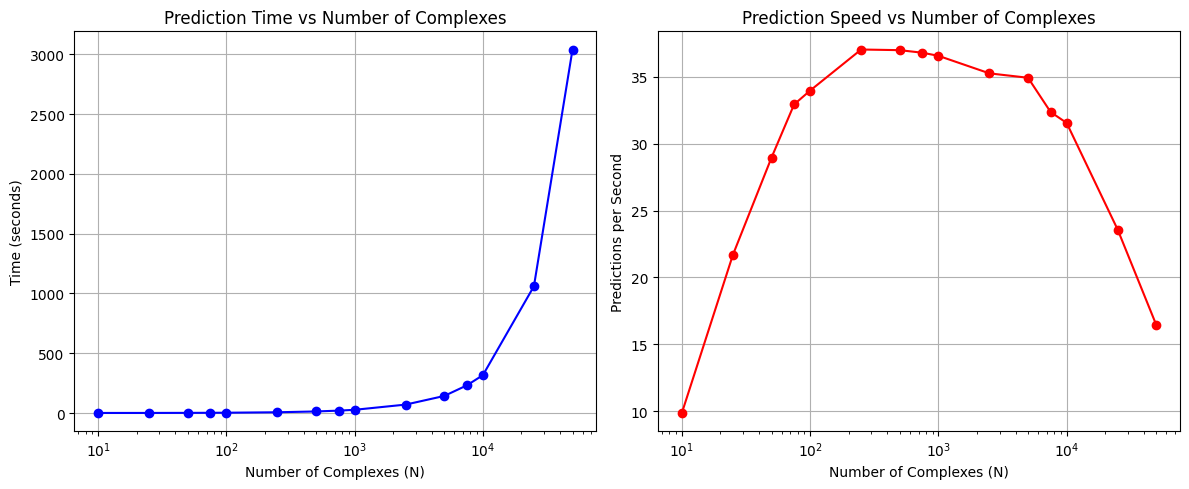


✓ Benchmark complete!


In [14]:
# Plot results if matplotlib is available
try:
    import matplotlib.pyplot as plt
    
    if len(successful_results) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Time vs N
        ax1.plot(successful_results['N'], successful_results['time_seconds'], 'b-o')
        ax1.set_xlabel('Number of Complexes (N)')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Prediction Time vs Number of Complexes')
        ax1.set_xscale('log')
        ax1.grid(True)
        
        # Plot 2: Speed vs N
        ax2.plot(successful_results['N'], successful_results['nb_per_second'], 'r-o')
        ax2.set_xlabel('Number of Complexes (N)')
        ax2.set_ylabel('Predictions per Second')
        ax2.set_title('Prediction Speed vs Number of Complexes')
        ax2.set_xscale('log')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('benchmark_results_plot.png')
        print(f"\n✓ Plot saved to 'benchmark_results_plot.png'")
        plt.show()
        
except ImportError:
    print("\n(Matplotlib not available for plotting)")

print("\n✓ Benchmark complete!")

In [15]:
1/38

0.02631578947368421